# Where to Build a Gym
 Seattle has been enjoying steady growth, and thanks to the combination of strong manufacturing companies like Boeing and newer technology
 companies such as Microsoft and Amazon, this growth is likely to continue for the near future.  This creates opportunities not simply for
 those in the technology sector, but also more traditional businesses seeking to serve this new clientel.  Among these are gyms, which are
 not only resistant to outsourcing (for obvious reasons), but also especially popular among the young population that Seattle is attracting.
 This leaves a question of where to build new venue.

In [1]:
import requests
import csv
import pandas as pd
import numpy as np
from statistics import mean
from statistics import stdev
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import math
import folium
from os import listdir  # used to gather names of files in folder
from shapely.geometry import Point, Polygon
import json
#from shapely.geometry import shape, mapping, Point, Polygon, MultiPolygon
import geojson
#from geojson import feature_collection
from pandas.io.json import json_normalize
from colour import Color
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler


In [2]:
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################


###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################


###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################


In [3]:
def FindClosest(lats, longs):
    closest = []
    for i1, (lat1, lng1) in enumerate(zip(lats, longs)):
        distances = []
        for i2, (lat2, lng2) in enumerate(zip(lats, longs)):
            if (i1==i2):
                continue
            d = Haversine(lat1,lng1,lat2,lng2)
            distances.append(d)
        closest.append(min(distances))
    return closest
#    point = shape(pt['geometry'])
#    return point.within(shape(multi['geometry'])):

def Haversine(lat1,lng1,lat2,lng2, unit = 'meters'):
    # Based on Nathan A. Rooy's function
    R = 6361000     # earth radius in meters

    phi_1=math.radians(lat1)
    phi_2=math.radians(lat2)
    delta_phi=math.radians(lat2-lat1)
    delta_lambda=math.radians(lng2-lng1)

    a=math.sin(delta_phi/2.0)**2+\
        math.cos(phi_1)*math.cos(phi_2)*\
        math.sin(delta_lambda/2.0)**2
    c=2*math.atan2(math.sqrt(a),math.sqrt(1-a))
    r = R * c
    if unit == 'meters':
        return r
    r = r / 1000
    if unit == 'km' or unit == 'kilometers':
        return r
    r = r * 0.621371
    if unit == 'miles':
        return r
    r = r / 5280 
    if unit == 'feet':
        return r

def Haversine(latlong1,latlong2, unit = 'meters'):
    # Based on Nathan A. Rooy's function
    R = 6361000     # earth radius in meters
    lat1,lng1 = latlong1[0], latlong1[1]
    lat2,lng2 = latlong2[0], latlong2[1]
    phi_1=math.radians(lat1)
    phi_2=math.radians(lat2)
    delta_phi=math.radians(lat2-lat1)
    delta_lambda=math.radians(lng2-lng1)

    a=math.sin(delta_phi/2.0)**2+\
        math.cos(phi_1)*math.cos(phi_2)*\
        math.sin(delta_lambda/2.0)**2
    c=2*math.atan2(math.sqrt(a),math.sqrt(1-a))
    r = R * c
    if unit == 'meters':
        return r
    r = r / 1000
    if unit == 'km' or unit == 'kilometers':
        return r
    r = r * 0.621371
    if unit == 'miles':
        return r
    r = r / 5280 
    if unit == 'feet':
        return r

def PrimitiveCenter(coordinates, flip = False):
# This function simply averages the X and Y coordinates of a json or geojson polygon.
# It is simple, but will favor the side with the most complicated geometry
    Xs, Ys = [],[]
    for pt in coordinates:
        Xs.append(pt[0])
        Ys.append(pt[1])
    if flip:
        return [mean(Ys),mean(Xs)]    
    return [mean(Xs),mean(Ys)]

In [4]:
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################


In [5]:

def LatLong(address):
    if type (address) == list:
        lats = []
        longs = []
        for a in address:
            lat, lng = LatLong(a)

            lats.append(lat)
            longs.append(lng)
        return lats, longs
    slash = address.find('/')
    if slash != -1:
        address = address[0:slash]
    del slash
    dash = address.find('-')
    if dash != -1:
        lats = []
        longs = []
        comma = address.find(',')
        remainder = address[comma:]
        for a in address[0:comma].split('-'):
            lat, lng = LatLong(f'{a}{remainder}')
            if lat == -49.51 and lng == -128.34:
                continue
            else:
                lats.append(lat)
                longs.append(lng)
        return mean(lats), mean(longs)
    geolocator = Nominatim(user_agent="foursquare_agent")
    try:
        loc = geolocator.geocode(address)
        return loc.latitude, loc.longitude
    except:
        print(f'ERROR AT: {address}')
        return -49.51, -128.34

def GetManyNearbyVenues(names, lats, longs, limit = 100,  radius = 500, radi = 0,nType = 'Neighborhood'):
# This function is designed to work with a single or varying radi
    if type(radi) == int:
        return GetManyNearbyVenuesSingleRadius(names,lats,longs,limit,radius,nType)
    else:
#        print("Multiple Radi")
        return GetManyNearbyVenuesMultiRadi(names = names, lats = lats, longs = longs, limit = limit, radi = radi, nType = nType)

def GetManyNearbyVenuesMultiRadi(names, lats, longs, limit, radi, nType):
    if type(names) == str:
        names = names.split(',')
    l_venues = []
    # long is taken
#    print('Starting Loop')
    for name, lat, lng, radius in zip(names, lats, longs, radi):
        results = GetNearbyVenues(name, lat, lng, radius, limit)
#        print(results)
        l_venues.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for l_venues in l_venues for item in l_venues])
    nearby_venues.columns = [f'{nType}',
            f'{nType} Latitude',f'{nType} Longitude',
            'Venue',
            'Venue Latitude','Venue Longitude',
            'Venue Category']
    return nearby_venues

def GetManyNearbyVenuesSingleRadius(names, lats, longs, limit, radius,nType):
    #ensure names is a list
    if type(names) == str:
        names = names.split(',')
    l_venues = []
    # long is taken
    for name, lat, lng in zip(names, lats, longs):
        results = GetNearbyVenues(name, lat, lng, radius, limit)
        l_venues.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for l_venues in l_venues for item in l_venues])
    nearby_venues.columns = [f'{nType}',
            f'{nType} Latitude',f'{nType} Longitude',
            'Venue',
            'Venue Latitude','Venue Longitude',
            'Venue Category']
    return nearby_venues
# split the function in two to make it more easily tested

def GetNearbyVenues(name, lat, lng, radius, limit):
    url = FSExploreLoc(lat, lng, LIMIT = limit, RADIUS = radius)
    try:
        return requests.get(url).json()["response"]['groups'][0]['items']
    except:
        print(f'Error at {name}, lat {lat} and lng {lng}')
        return(FSExploreLoc())

def FSExploreLoc(latitude=43.75880, longitude=-79.320197, CLIENT_ID = 'RJ2TAOE50JVYUTGUY0W0HNVMEWPHWN4LJJ2CSVJL1NYUY43P', CLIENT_SECRET = 'WV3VMFHZINCZWXWH1VKWWVWNFD3I1XWY2IFFXI5KJPGHUM3G', VERSION = '20180605', LIMIT = 100, RADIUS = 500):
    return f'https://api.foursquare.com/v2/venues/explore?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={latitude},{longitude}&v={VERSION}&limit={LIMIT}&radius={RADIUS}'


def FSVenueSearch(venueCategory,latitude=43.75880, longitude=-79.320197, CLIENT_ID = 'RJ2TAOE50JVYUTGUY0W0HNVMEWPHWN4LJJ2CSVJL1NYUY43P', CLIENT_SECRET = 'WV3VMFHZINCZWXWH1VKWWVWNFD3I1XWY2IFFXI5KJPGHUM3G', VERSION = '20180605', LIMIT = 100, RADIUS = 500):
    return f'https://api.foursquare.com/v2/venues/search?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={latitude},{longitude}&v={VERSION}&query={venueCategory}&radius={RADIUS}&limit={LIMIT}'

def FSVenueSearch(venueCategory, latlong, CLIENT_ID = 'RJ2TAOE50JVYUTGUY0W0HNVMEWPHWN4LJJ2CSVJL1NYUY43P', CLIENT_SECRET = 'WV3VMFHZINCZWXWH1VKWWVWNFD3I1XWY2IFFXI5KJPGHUM3G', VERSION = '20180605', LIMIT = 100, RADIUS = 500):
    return f'https://api.foursquare.com/v2/venues/search?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={latlong[0]},{latlong[1]}&v={VERSION}&query={venueCategory}&radius={RADIUS}&limit={LIMIT}'


In [6]:
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################


In [7]:
def MultiConcatenate(ll, s, append = True):
    rList = [] # was getting crazy errors while modifying ll directly    
    # This function appends (by default) of pre-pends (...there's a word for that) a string to all elements in a list
    if append:
        if type(s) == str:
            for l in ll:
                rList.append(f'{l}, {s}')
        else:
            for l, s2 in zip(ll, s):
                rList.append(f'{l}, {s2}')
    else:
        if type(s) == str:
            for l in ll:
                rList.append(f'{l}{s}')
        else:    
            for l, s2 in zip(ll, s):
                rList.append(f'{l}, {s2}')
    return (rList)


def RemoveBrackets(s,t='all'):
    if t=='all':
        s = RemoveBrackets(s,'()')
        s = RemoveBrackets(s,'[]')
        s = RemoveBrackets(s,'{}') # off-coloring does not mean an error here
        return s
    while True:
        startCut = s.find(t[0])
        if startCut ==-1:
            break
        endCut = s.find(t[1]) +1
        s = f"{s[0:startCut]}{s[endCut:]}"
    return s

def RemoveSymbol(s,t):
    length = len(t)
    while True:
        startCut = s.find(t)
        if startCut ==-1:
            break
        endCut = startCut + length
        s = f"{s[0:startCut]}{s[endCut:]}"
    return s
    
def BoolToIndex(ll):
    these = []
    for i, l in enumerate(ll):
        if l:
            these.append(i)
    return these

def fileToName(name):
    dot = name.find('.')
    name = name[0:dot]
    if name.find('_')!=-1:
        name = [f'{n.capitalize()}' for n in name.split('_')]
        name2 = ''
        for n in name:
            name2 = f'{name2} {n}'
            name = name2[1:]
    else:
        name = name.capitalize()
    return name


In [8]:
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################


###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################


###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################

## Data Gathering
   To examine the question of where to build, we will examine three sources of data.  The first of these is a map of Seattle's districts in
 the geojson that was assembled by Zillow.  The second is data projecting the growth of key urban centers and villages assembled by the
 Seattle government.  The third is data on where gyms are located, using Foursquare.
   To combine these datasets, we will be using Zillow's list of neighborhoods as the boundaries they provide are the most reliable.  We will
 then be using the pt.within() method to place the Seattle Government's data on villages and urban centers into Zillow's neighborhoods.  We
 will similarly get gym counts for each Zillow neighborhood.

### Data Gathering: Seattle Government Data
   Seattle's government data was in pdf format.  Unfortunately, the tabula module was unable to extract useable data from most of the pages,
 so we instead relied on more traditional forms of data-entry, and read then read the data from a csv file.  Then using Nominatim, we acquire
 GPS coordinates for each district, and individually correct any erroneous coordinates.  Finally, zillow's geojson files are checked to see
 where each urban center or village is located within the zillow neighborhoods.  The final product is the panda's dataframe geoSeattleGrowth

In [9]:
# Gather the data
###########################################################################################################################
###########################################################################################################################

seattleGrowth = pd.read_csv('seattleGrowth.csv', delimiter=',')  # this will be deleted later to save space

#seattleGrowth = pd.DataFrame(seattleGrowth)

addresses = MultiConcatenate(seattleGrowth['Community'], 'Seattle, WA, USA')
lats, longs = LatLong(addresses)
seattleGrowth['Latitude']=lats
seattleGrowth['Longitude']=longs


# FIX PROBLEMATIC NEIGHBORHOODS
these = BoolToIndex(seattleGrowth['Community'] == 'West Seattle Junction')
seattleGrowth.loc[these,['Latitude','Longitude']] = [47.562216,-122.386808]
these = BoolToIndex(seattleGrowth['Community'] == 'Ballard')
seattleGrowth.loc[these,['Latitude','Longitude']] = [47.669, -122.386]
these = BoolToIndex(seattleGrowth['Community'] == 'Roosevelt')
seattleGrowth.loc[these,['Latitude','Longitude']] = [47.678048, -122.315720]
these = BoolToIndex(seattleGrowth['Community'] == 'Greater Duwamish')
seattleGrowth.loc[these,['Latitude','Longitude']] = [47.554512, -122.313516]
these = BoolToIndex(seattleGrowth['Community'] == 'Pike/Pine')  # east of highway, not pike marketplace
seattleGrowth.loc[these,['Latitude','Longitude']] = [47.614652, -122.319427]
these = BoolToIndex(seattleGrowth['Community'] == 'Commercial Core')# basically downtown
seattleGrowth.loc[these,['Latitude','Longitude']] = [47.605132, -122.335159]
these = BoolToIndex(seattleGrowth['Community'] == 'Ballard-Interbay-Northend') # original point was just outside district.
seattleGrowth.loc[these,['Latitude','Longitude']] = [47.640944, -122.381903]
these = BoolToIndex(seattleGrowth['Community'] == 'Denny Triangle') # point was on line w/ downtown, moved to NW corner of Denny Park.
seattleGrowth.loc[these,['Latitude','Longitude']] = [47.619689, -122.342360]
these = BoolToIndex(seattleGrowth['Community'] == 'Upper Queen Anne') # was not even in Seattle...
seattleGrowth.loc[these,['Latitude','Longitude']] = [47.632160, -122.356903]
these = BoolToIndex(seattleGrowth['Community'] == 'Capital hill') # was not even in Seattle...
seattleGrowth.loc[these,['Latitude','Longitude']] = [47.623164, -122.322014]


ERROR AT: Pioneer Square, Seattle, WA, USA
ERROR AT: West Seattle Junction, Seattle, WA, USA
ERROR AT: Northend, Seattle, WA, USA
ERROR AT: Greater Duwamish, Seattle, WA, USA


In [10]:
# Place the Data into a cleaned-up dataset
###########################################################################################################################
###########################################################################################################################

geoSeattleGrowth = pd.DataFrame()
geoSeattleGrowth['Neighborhood']        = list(fileToName(f) for f in listdir('geojson'))
geoSeattleGrowth['growth_2015-2030']    = [0] * geoSeattleGrowth.shape[0]
geoSeattleGrowth['beingBuilt']          = [0] * geoSeattleGrowth.shape[0]
geoSeattleGrowth['total2015']           = [0] * geoSeattleGrowth.shape[0]
geoSeattleGrowth['recentBuilt']         = [0] * geoSeattleGrowth.shape[0]
geoSeattleGrowth['total2019']           = [0] * geoSeattleGrowth.shape[0]
geoSeattleGrowth['fileName'] = listdir('geojson')


these= [True] * seattleGrowth.shape[0]

# just want a list of true bools of equal length to seattleGrowth

for k, f in enumerate(geoSeattleGrowth.fileName):
    with open (f'geojson\\{f}') as geo:
        neighborhood = json.load(geo)
        neighborhood = Polygon(neighborhood['coordinates'][0][0])
    for i, (x,y) in enumerate(zip(seattleGrowth.Longitude, seattleGrowth.Latitude)):
#   In X,Y coordinates, it is LONGITUDE and latitude...Eastwest before NorthSouth
        if these[i]:
            pt = Point(x,y)
            if pt.within(Polygon(neighborhood)):
                geoSeattleGrowth.loc[k,'growth_2015-2030']  += seattleGrowth.loc[i,'Estimated_Growth_2015-2035']
                geoSeattleGrowth.loc[k,'beingBuilt']        += seattleGrowth.loc[i,'Being_Built']
                geoSeattleGrowth.loc[k,'total2015']         += seattleGrowth.loc[i,'Total_Units_2015']                
                geoSeattleGrowth.loc[k,'recentBuilt']       += seattleGrowth.loc[i,'Units_Built_2016-2019']
                geoSeattleGrowth.loc[k,'total2019']         += seattleGrowth.loc[i,'Total_Units_2019']
#                geoNeighborhood[i] = fileToName(f)
                these[i]=False
#seattleGrowth['GeoNeighborhood']= geoNeighborhood
#seattleGrowth[['Community','GeoNeighborhood', 'Latitude','Longitude']]

del seattleGrowth
geoSeattleGrowth.head()


,Neighborhood,growth_2015-2030,beingBuilt,total2015,recentBuilt,total2019,fileName
0,Admiral,300,112,1134,161,1295,admiral.geojson
1,Arbor Heights,0,0,0,0,0,arbor_heights.geojson
2,Atlantic,0,0,0,0,0,atlantic.geojson
3,Ballard,4000,486,9881,1520,11401,ballard.geojson
4,Beacon Hill,800,166,2908,246,3154,beacon_hill.geojson


In [11]:
# SHRINK DATASET TO NEIGHBORHOODS OF INTEREST
#these = geoSeattleGrowth['total2019']>0
#geoSeattleGrowth = geoSeattleGrowth[these]
#del these
#geoSeattleGrowth


In [12]:
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################


## Data Gathering: Venue Data
   Ideally, we would gather a list of Seattle Gyms from a single query, or by querring each neighborhood individually.  Unfortunatley,
 querries are made within a radius of a GSP coordinate, and neither Seattle nor its neighborhoods are circles.  Further, a single query
 to FourSquare can only return upto 50 venues.  Thus, we divided Seattle into 12 overlapping circular regions to query, and then removed
 any duplicate venues that arose from the overlap of these.  We then use DBSCAN to check for geographic clusters of gyms within the data.
 At the end, we add the gym counts for each neighborhood are added to the geoSeattleGrowth dataset.

In [13]:
# Get the circles for acquiring venues
###########################################################################################################################
###########################################################################################################################
northernCenter      = [47.668000, -122.328000]
southernCenter      = [47.540000, -122.321886]
westernCenter       = [47.637000, -122.376500] #at North Queen Anne
westernCenter2      = [47.656000, -122.406000]
easternCenter       = [47.650000, -122.275500]
northernCenter2     = [47.706000, -122.342000]
seattleCoreLatLong  = [47.619000, -122.353000]
seattleCoreLatLong2 = [47.611500, -122.346000]
seattleCoreLatLong3 = [47.611000, -122.333518]
valleyGap           = [47.626251, -122.345750]
dennyGap            = [47.618070, -122.338533]
freemontGap         = [47.650936, -122.352430]

rNorth2 = Haversine(northernCenter2, northernCenter) * 1.40
rWest = Haversine(westernCenter, seattleCoreLatLong) * 0.87
rWest2 = Haversine(westernCenter2, westernCenter)/2**0.5 * 1.2
rEast = Haversine(easternCenter, seattleCoreLatLong) * 0.85
rSouth = Haversine(southernCenter, seattleCoreLatLong) * .90
rCore = 700
rCore2 = 600
rCore3 = 500
rValley = 600
rDenny = 650
rFreemont = 500

# originally used two centers, but northern center had two many gyms, now using four centers

In [14]:
# Query each circle
###########################################################################################################################
###########################################################################################################################

targetCategory = 'Gym'

url = FSVenueSearch(targetCategory,latlong =  northernCenter2, RADIUS = rNorth2)
seattleVenues = requests.get(url).json()['response']['venues']
seattleVenues = json_normalize(seattleVenues)
seattleVenues = seattleVenues[['id','name','location.lat','location.lng']]
print(f'North {seattleVenues.shape}')

url = FSVenueSearch(targetCategory,latlong =  valleyGap, RADIUS = rValley)
valleyVenues = requests.get(url).json()['response']['venues']
valleyVenues = json_normalize(valleyVenues)
valleyVenues = valleyVenues[['id','name','location.lat','location.lng']]
print(f'Valley {valleyVenues.shape}')

seattleVenues = valleyVenues.append(valleyVenues)
print(f'Venues: {seattleVenues.shape}')
del valleyVenues

url = FSVenueSearch(targetCategory,latlong =  dennyGap, RADIUS = rDenny)
dennyVenues = requests.get(url).json()['response']['venues']
dennyVenues = json_normalize(dennyVenues)
dennyVenues = dennyVenues[['id','name','location.lat','location.lng']]
print(f'Denny {dennyVenues.shape}')

seattleVenues = seattleVenues.append(dennyVenues)
print(f'Venues: {seattleVenues.shape}')
del dennyVenues

url = FSVenueSearch(targetCategory,latlong =  freemontGap, RADIUS = rFreemont)
freemontVenues = requests.get(url).json()['response']['venues']
freemontVenues = json_normalize(freemontVenues)
freemontVenues = freemontVenues[['id','name','location.lat','location.lng']]
print(f'Denny {freemontVenues.shape}')

seattleVenues = seattleVenues.append(freemontVenues)
print(f'Venues: {seattleVenues.shape}')
del freemontVenues

url = FSVenueSearch(targetCategory,latlong =  seattleCoreLatLong, RADIUS = rCore)
coreSeattleVenues = requests.get(url).json()['response']['venues']
coreSeattleVenues = json_normalize(coreSeattleVenues)
coreSeattleVenues = coreSeattleVenues[['id','name','location.lat','location.lng']]
print(f'Core {coreSeattleVenues.shape}')

seattleVenues = seattleVenues.append(coreSeattleVenues)
print(f'Venues: {seattleVenues.shape}')
del coreSeattleVenues

url = FSVenueSearch(targetCategory,latlong =  seattleCoreLatLong2, RADIUS = rCore2)
coreSeattleVenues2 = requests.get(url).json()['response']['venues']
coreSeattleVenues2 = json_normalize(coreSeattleVenues2)
coreSeattleVenues2 = coreSeattleVenues2[['id','name','location.lat','location.lng']]
print(f'South Core {coreSeattleVenues2.shape}')

seattleVenues = seattleVenues.append(coreSeattleVenues2)
print(f'Venues: {seattleVenues.shape}')
del coreSeattleVenues2

url = FSVenueSearch(targetCategory,latlong =  seattleCoreLatLong3, RADIUS = rCore3)
coreSeattleVenues3 = requests.get(url).json()['response']['venues']
coreSeattleVenues3 = json_normalize(coreSeattleVenues3)
coreSeattleVenues3 = coreSeattleVenues3[['id','name','location.lat','location.lng']]
print(f'Southeast Core {coreSeattleVenues3.shape}')

seattleVenues = seattleVenues.append(coreSeattleVenues3)
print(f'Venues: {seattleVenues.shape}')
del coreSeattleVenues3

url = FSVenueSearch(targetCategory,latlong =  westernCenter, RADIUS = rWest)
westernSeattleVenues = requests.get(url).json()['response']['venues']
westernSeattleVenues = json_normalize(westernSeattleVenues)
westernSeattleVenues = westernSeattleVenues[['id','name','location.lat','location.lng']]
print(f'West {westernSeattleVenues.shape}')

seattleVenues = seattleVenues.append(westernSeattleVenues)
print(f'Venues: {seattleVenues.shape}')
del westernSeattleVenues

url = FSVenueSearch(targetCategory,latlong =  westernCenter2, RADIUS = rWest2)
westernSeattleVenues2 = requests.get(url).json()['response']['venues']
westernSeattleVenues2 = json_normalize(westernSeattleVenues2)
westernSeattleVenues2 = westernSeattleVenues2[['id','name','location.lat','location.lng']]
print(f'Far West {westernSeattleVenues2.shape}')

seattleVenues = seattleVenues.append(westernSeattleVenues2)
print(f'Venues: {seattleVenues.shape}')
del westernSeattleVenues2

url = FSVenueSearch(targetCategory,latlong =  easternCenter, RADIUS = rEast)
easternSeattleVenues = requests.get(url).json()['response']['venues']
easternSeattleVenues = json_normalize(easternSeattleVenues)
easternSeattleVenues = easternSeattleVenues[['id','name','location.lat','location.lng']]
print(f'East {easternSeattleVenues.shape}')

seattleVenues = seattleVenues.append(easternSeattleVenues)
print(f'Venues: {seattleVenues.shape}')
del easternSeattleVenues

url = FSVenueSearch(targetCategory,latlong =  southernCenter, RADIUS = rSouth)
southSeattleVenues = requests.get(url).json()['response']['venues']
southSeattleVenues = json_normalize(southSeattleVenues)
southSeattleVenues = southSeattleVenues[['id','name','location.lat','location.lng']]
print(f'South {southSeattleVenues.shape}')

seattleVenues = seattleVenues.append(southSeattleVenues)
print(f'Venues: {seattleVenues.shape}')
del southSeattleVenues

seattleVenues.drop_duplicates(inplace = True)
print(f'Final Venues: {seattleVenues.shape}')


North (28, 4)
Valley (7, 4)
Venues: (14, 4)
Denny (46, 4)
Venues: (60, 4)
Denny (3, 4)
Venues: (63, 4)
Core (43, 4)
Venues: (106, 4)
South Core (38, 4)
Venues: (144, 4)
Southeast Core (39, 4)
Venues: (183, 4)
West (32, 4)
Venues: (215, 4)
Far West (27, 4)
Venues: (242, 4)
East (25, 4)
Venues: (267, 4)
South (40, 4)
Venues: (307, 4)
Final Venues: (179, 4)


In [15]:
# Use DBSCAN to place venues into clusters
###########################################################################################################################
###########################################################################################################################

df_temp = seattleVenues[['location.lat','location.lng']]
df_temp = StandardScaler().fit_transform(df_temp)

epsilon = 0.20
sklearn.utils.check_random_state(1000)
db = DBSCAN(eps = epsilon, min_samples = 4).fit(df_temp)

seattleVenues['Cluster']=db.labels_

del df_temp



In [16]:
# Put venue counts in zilllow geoSeattleGrowth
###########################################################################################################################
###########################################################################################################################
these = [True] * len(seattleVenues)
venueNeighborhood = ['    000'] * len(seattleVenues)
venueCount = [0] * geoSeattleGrowth.shape[0]

for k, f in enumerate(geoSeattleGrowth.fileName):
    with open (f'geojson\\{f}') as geo:
        neighborhood = json.load(geo)
        neighborhood = Polygon(neighborhood['coordinates'][0][0])
    for i, (lat,lng) in enumerate(zip(seattleVenues['location.lat'],seattleVenues['location.lng'])):

        if these[i]:
            pt = Point(lng,lat) # X IS LONGITUDE, y is latitude

            if pt.within(Polygon(neighborhood)):
                these[i] = False  #prevents repeats, cannot put earlier, else it will ruin the for-loop
                venueNeighborhood[i] = fileToName(f)

                venueCount[k] = venueCount[k] +1


geoSeattleGrowth['GymCounts'] = venueCount
geoSeattleGrowth.head()


,Neighborhood,growth_2015-2030,beingBuilt,total2015,recentBuilt,total2019,fileName,GymCounts
0,Admiral,300,112,1134,161,1295,admiral.geojson,0
1,Arbor Heights,0,0,0,0,0,arbor_heights.geojson,0
2,Atlantic,0,0,0,0,0,atlantic.geojson,0
3,Ballard,4000,486,9881,1520,11401,ballard.geojson,17
4,Beacon Hill,800,166,2908,246,3154,beacon_hill.geojson,2


In [17]:
zGeoSeattleGrowth = {}
# string data
for c in geoSeattleGrowth.columns[0:1]:
    zGeoSeattleGrowth[c] = geoSeattleGrowth[c]
# numeric data to zscores
for c in geoSeattleGrowth.columns[1:6]:
    zGeoSeattleGrowth[c] = (geoSeattleGrowth[c] - mean(geoSeattleGrowth[c]))/stdev(geoSeattleGrowth[c])
for c in geoSeattleGrowth.columns[6:]:
    zGeoSeattleGrowth[c] = geoSeattleGrowth[c]
zGeoSeattleGrowth = pd.DataFrame(zGeoSeattleGrowth)
zGeoSeattleGrowth.head()


,Neighborhood,growth_2015-2030,beingBuilt,total2015,recentBuilt,total2019,fileName,GymCounts
0,Admiral,-0.298860,-0.206423,-0.225709,-0.202293,-0.232085,admiral.geojson,0
1,Arbor Heights,-0.486271,-0.397759,-0.532669,-0.385680,-0.529240,arbor_heights.geojson,0
2,Atlantic,-0.486271,-0.397759,-0.532669,-0.385680,-0.529240,atlantic.geojson,0
3,Ballard,2.012546,0.432503,2.142005,1.345678,2.086868,ballard.geojson,17
4,Beacon Hill,0.013492,-0.114172,0.254493,-0.105473,0.194486,beacon_hill.geojson,2


In [18]:
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################

In [19]:
#### Gather Data: Zillow Neighborhood Geojson
#   Up until now, we had simply been pulling in geojson files for individual neighborhoods as needed.  However, some of the
# mapping functions work much better with a single FeatureCollection of neighborhoods than separate files.  Here, we joined
# the Geojson files together, then wrote them to a new file.  To speed up the program, the program was then simply modified
# to read the combined geojson directly.


In [20]:
# Making the Geojson file.  Commented out as not currently in use
###########################################################################################################################
###########################################################################################################################

these = geoSeattleGrowth['total2019']!=0
features = []
for name, file in zip(geoSeattleGrowth[these]['Neighborhood'], geoSeattleGrowth[these]['fileName']):

#for file in listdir('geojson'):   # keep these commented out unless you want all Seattle neighborhoods
#    name = fileToName(file)       # keep these commented out unless you want all Seattle neighborhoods

    path = f'geojson\\{file}'
    nFeature = {'type': "Feature", "properties": {"name": name}, "geometry": {"type": "Polygon", "coordinates": [] }, "id": name}
    nFeature['geometry']['coordinates'] = []
    with open(path) as f:
        coordinates = json.load(f)
    for c in coordinates['coordinates']:
        nFeature['geometry']['coordinates'].append(c[0])
    features.append(nFeature)

geoSeattleNeighborhoodsPartial = {"type" : "FeatureCollection", "features": []}
geoSeattleNeighborhoodsPartial['features']=features
with open('seattleNeighborhoodsPartial.txt','w') as outfile:
    json.dump(geoSeattleNeighborhoodsPartial,outfile)
#geoSeattleNeighborhoodsPartial = json.dumps(geoSeattleNeighborhoodsPartial)


In [21]:
# Read the combined geojson file into seattleNeighborhoods.geojson
###########################################################################################################################
###########################################################################################################################

with open('seattleNeighborhoods.geojson') as file:
    geoSeattleNeighborhoods = json.load(file)


In [22]:
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################


###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################


###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################

## Data Analysis
  Our data consists of expected growth in important urban centers and villages through Seattle, gym counts for each
 neighborhood, and the locations of each of these venues.  We are not delving into issues of financing a gym at this
 point (though one can safely assume that anything downtown would be more expensive to run).  Therefore, we will be
 looking at two different visuals: a bar graph and map of the combined data.
### The Histogram
   Using a simple hisogram, it becomes apparent that most Seattle neighborhoods have few to no gyms.  To put it another
 way, less than 10% of the neighborhoods have more than 90% of the gyms.

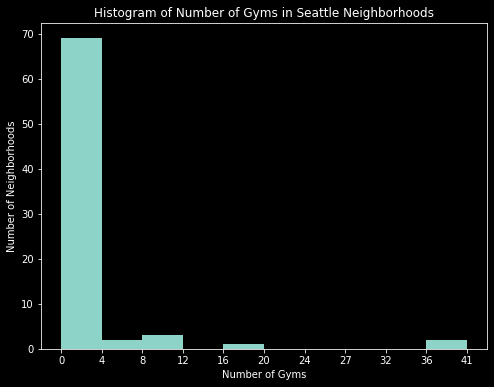

In [23]:
###########################################################################################################################
###########################################################################################################################

count, bin_edges = np.histogram(geoSeattleGrowth['GymCounts'])
labels = ('0','4','8','12','16','20','24','27','32','36','41')

geoSeattleGrowth['GymCounts'].plot(kind = 'hist', figsize = (8,6))

plt.xticks(bin_edges, labels)
plt.title('Histogram of Number of Gyms in Seattle Neighborhoods')
plt.ylabel('Number of Neighborhoods')
plt.xlabel('Number of Gyms')

plt.show()


### The Bar Graph
   The bar graph shows Seattle's 2015 housing stock (divided by 100), its projected 2030 housing stock, and the number
 of gyms in the neighborhood.  Several districts that stand out are Capitol Hill, South Lake Union, Belltown, Ballard,
 and unsurprisingly downtown.
   Downtown is notable for its modest housign stock compraed to having the most number of gyms of any neighborhood.  This
 is in marked contrast to Capitol Hill, which has few gyms but the most housing stock of any neighborhood in Seattle.  It
 is likely that many Capitol Hill residents simply go to Downtown to use the gym.
   Belltown and Ballard both stand out for having plenty of housing stock as well as large numbers of gyms.  Belltown though, is adjoining Downtown, so it is likely that some of the
 neighborhood has simply been subsumed into the central commercial district that is downtown.  Both even have
 healthy growth projections over the next decade--suggesting that both districts would be good places to open a new gym.
   Finally, South Lake Union stands out for having the highest projected growth of any neighborhood in Seattle.  The small
 number of gyms relative to the projected growth suggest this would be an excellent place to open a new gym to cater to new
 comers.

In [24]:
###########################################################################################################################
###########################################################################################################################
df_temp = geoSeattleGrowth[['Neighborhood','total2015','growth_2015-2030','GymCounts']]
df_temp['total'] = df_temp.total2015 + df_temp['growth_2015-2030']
df_temp.sort_values(['total'], ascending = False, inplace = True, axis = 0)
df_temp = df_temp[df_temp.total>0]

c:\Users\cmp53\desktop\projects\coursera_capstone\FinalProjectPdfSoup.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # companies such as Microsoft and Amazon, this growth is likely to continue for the near future.  This creates opportunities not simply for
c:\Users\cmp53\desktop\projects\coursera_capstone\FinalProjectPdfSoup.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # those in the technology sector, but also more traditional businesses seeking to serve this new clientel.  Among these are gyms, which are


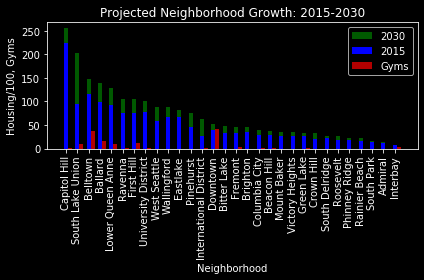

In [25]:
###########################################################################################################################
###########################################################################################################################
fig, ax = plt.subplots()
index = np.arange(df_temp.shape[0])
labels = df_temp['Neighborhood']
bar_width = 0.35
opacity = 0.7


t2030 = plt.bar (index, df_temp['total']/100, bar_width, alpha = opacity, color = 'g', label = '2030')
t2015 = plt.bar (index, df_temp['total2015']/100, bar_width, alpha = 1, color = 'b', label = '2015')
tGyms = plt.bar (index + bar_width, df_temp['GymCounts'], bar_width, alpha = opacity, color = 'r', label = 'Gyms')
plt.xlabel('Neighborhood')
plt.ylabel('Housing/100, Gyms')
plt.title('Projected Neighborhood Growth: 2015-2030')
plt.xticks(rotation = 90)
plt.xticks(index, labels)

plt.legend()


plt.tight_layout()
plt.show()
del df_temp


In [26]:
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################


### The Map
   This Seattle Map consists is showing two things: the projected growth of various neighborhoods in Seattle (by z-score) and
 and the locations of different gyms by cluster.  Clicking on the red circle in each neighborhood gives its name.  Districts
 with a more redish shading are expected to have higher growth by 2030.  Keep in mind that Seattle did not include all of its
 neighborhoods in its growth projections, so not all neighborhoods labeled as low-growth are low-growth.  Meanwhile, the venues
 have been clustered using DBSCAN, revealing two clusters cromprising most of the gyms, and many scattered orphan gyms that do
 not belong to any cluster.
   The map both supplements insights of the bar graph and provides some of its own.  The two neighborhoods with the most gyms:
 Downtown and Ballard, are also both centers of the two gym clusters.  Meanwhile, many neighborhoods have few or no gyms at all,
 suggesting that there are ample opportunities to open a new venue--some of which also have good growth projections.  However,
 one important caveat is that FourSquare's data is not complete.  The University District for instance, is missing both of the
 University of Washington's gyms.  If opening a gym in Seattle is no more difficult than opening a brewery, there should be
 it should be relatively easy to get started.

In [27]:
###########################################################################################################################
###########################################################################################################################

neighSeattleMap = folium.Map(seattleCoreLatLong, zoom_start=12) # generate map centred around Ecco

#style_function = (lambda feature : dict(fillColor = feature, color = 'purple', fillOpacity = 0.5))

neighSeattleMap.choropleth(
    geo_data = geoSeattleNeighborhoodsPartial,
    data = geoSeattleGrowth,
    columns = ['Neighborhood','growth_2015-2030'],
    key_on = 'feature.id',
    fill_color='YlOrRd'
)

these = geoSeattleGrowth['total2019']==0

for f in zGeoSeattleGrowth[these].fileName:
    with open (f'geojson\\{f}') as f2:
        this = json.load(f2)
    style_function = lambda this: dict(fillColor = "green", color = "green", fillOpacity = 0.2)
    folium.GeoJson(this,
     style_function= style_function
     ).add_to(neighSeattleMap)

#neighSeattleMap

for neigh in geoSeattleNeighborhoods['features']:
    coord = neigh['geometry']['coordinates']
    name = neigh['id']
    if name == 'Industrial District':
        continue
#        pt = [-122.364524, 47.574154] # lat and long are reversed for x and y
    else:
        pt = PrimitiveCenter(coord[0], flip = True)
#    print(pt)
#    del coord
    folium.CircleMarker(
        pt,
        radius = 5,
        popup = name,
        fill = True,
        color = 'red',
        fill_color = 'orange',
        fill_opacity = 0.5
    ).add_to(neighSeattleMap)
indPoints = [[47.577056,-122.363839],[47.580298,-122.351466],[47.567061,-122.335529]]
indNames = ['Industrial Center: West','Industrial Center: Harbor Island','Industrial Center: Main']
for pt, name in zip(indPoints, indNames):
    folium.CircleMarker(
        pt,
        radius = 5,
        popup = name,
        fill = True,
        color = 'red',
        fill_color = 'orange'
    ).add_to(neighSeattleMap)

colors = Color('blue')
colors = list(colors.range_to(Color("purple"),1+ max(seattleVenues['Cluster'])))
colors.append(Color("grey"))  # conveniently, DBSCAN orphans have a value of -1, so putting the orphan color last works perfectly.

for venue, lat, lng, cluster in zip(seattleVenues['name'], seattleVenues['location.lat'],seattleVenues['location.lng'], seattleVenues['Cluster']):
        folium.CircleMarker(
        [lat,lng],
        radius = 4,
        popup= venue,
        fill = True,
        color = str(colors[cluster]),
        fill_color = str(colors[cluster]),
        fill_opacity=.6
    ).add_to(neighSeattleMap)

neighSeattleMap


C:\Users\cmp53\AppData\Local\Programs\Python\Python37-32\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
